In [1]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.distance import PairwiseDistance
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
from tqdm import tnrange
from tqdm import tqdm_notebook

In [6]:
#device = torch.device('cuda')
device = torch.device('cpu')

In [3]:
def onehot(i,n):
    print(len(i))
    z = torch.zeros(i.shape[0], n)
    z[torch.arange(i.shape[0]), i]=1
    return z

In [4]:
class Images(torch.utils.data.Dataset):
    def __init__(self):
        D = np.r_[pd.read_csv("./mnist1.csv").to_numpy(), pd.read_csv("./mnist2.csv").to_numpy()]
        self.X = torch.Tensor(D[:, :-1].reshape(70000, 1, 28, 28))/255
        self.y = torch.Tensor(D[:, -1:]).long()
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :, :, :], self.y[idx, 0]
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)

In [7]:
Img = Images()
Img.to(device)

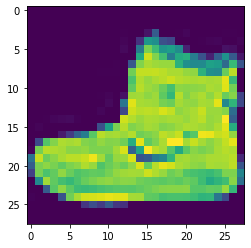

In [8]:
plt.imshow(Img[0][0].to(torch.device('cpu')).reshape(28,28));

In [8]:
ratio = 0.001
train, valid = torch.utils.data.random_split(Img, [int(len(Img)*(1 - ratio)), int(len(Img)*ratio)])

In [9]:
dataLoader = torch.utils.data.DataLoader(train, batch_size=2000)

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        a = 50
        b = 70
        c = 100
        d = 150
        
        self.conv10 = nn.Conv2d(1, a, 5)
        self.conv15 = nn.Conv2d(a, a, 5)
        self.conv20 = nn.Conv2d(a, b, 5)
        self.conv25 = nn.Conv2d(b, b, 5)
        self.conv30 = nn.Conv2d(b, c, 5)
        self.conv35 = nn.Conv2d(c, c, 5)
        self.conv40 = nn.Conv2d(c, d, 5)
        self.lin1 = nn.Linear(1350, 1000)
        self.lin2 = nn.Linear(1000, 500)
        self.lin3 = nn.Linear(500, 200)
        self.lin4 = nn.Linear(200, 10)
        
        self.pool = nn.MaxPool2d(2, return_indices=True)
        
    def forward(self, X):
        X = torch.relu(self.conv10(F.pad(X,(2,2,2,2))))

        X = torch.relu(self.conv15(F.pad(X,(2,2,2,2))))
        X, inda = self.pool(X)
        X = torch.relu(self.conv20(F.pad(X,(2,2,2,2))))
        
        X = torch.relu(self.conv25(F.pad(X,(2,2,2,2))))
        X, indb = self.pool(X)
        X = torch.relu(self.conv30(F.pad(X,(2,2,2,2))))
        
        X = torch.relu(self.conv35(F.pad(X,(2,2,2,2))))
        X, indb = self.pool(X)
        X = torch.relu(self.conv40(F.pad(X,(2,2,2,2))))
        
        X = X.view(X.shape[0], 1350)
        
        X = torch.relu(self.lin1(X))
        X = torch.relu(self.lin2(X))
        X = torch.relu(self.lin3(X))
        X = torch.sigmoid(self.lin4(X))
        
        return X

In [21]:
model = ConvNet().to(device)

In [22]:
opt = optim.Adam(model.parameters(), lr=0.001)

In [23]:
def CE(y, y_pred):
    y = y == 1
    return -torch.log(y_pred[y]).sum() - torch.log(1 - y_pred[~y]).sum() + 0

In [24]:

EPOCHS=10
for epoch in range(EPOCHS):
    i = 1
    for X, y in tqdm_notebook(dataLoader):
        model.zero_grad()
        L = CE(y, model.forward(X)) # + C*sum([torch.sum(model.state_dict()[a]**2) if a[-1] == 't' else 0 for a in model.state_dict()])
        L.backward()
        opt.step()

        # Print
        if (i % (len(dataLoader)//10)) == 0: print("Iteration %d \n        L: %.4f \n        CE: %d" % (i, L, CE(onehot(valid[:][1],10), model.forward(valid[:][0]))))
        i += 1
        
        torch.cuda.empty_cache()

70
Iteration 3 
        L: 12828.7939 
        CE: 291
70
Iteration 6 
        L: 8140.6299 
        CE: 333
70
Iteration 9 
        L: 7128.1763 
        CE: 259
70
Iteration 12 
        L: 6905.1416 
        CE: 245
70
Iteration 15 
        L: 6275.8926 
        CE: 249
70
Iteration 18 
        L: 5476.6851 
        CE: 239
70
Iteration 21 
        L: 5314.7710 
        CE: 250
70
Iteration 24 
        L: 3628.0190 
        CE: 335
70
Iteration 27 
        L: 3581.7266 
        CE: 414
70
Iteration 30 
        L: 2812.0195 
        CE: 545
70
Iteration 33 
        L: 2304.3074 
        CE: 896


70
Iteration 3 
        L: 3620.6602 
        CE: 1310
70
Iteration 6 
        L: 3105.7822 
        CE: 763
70
Iteration 9 
        L: 2218.0229 
        CE: 858
70
Iteration 12 
        L: 2265.8101 
        CE: 469
70
Iteration 15 
        L: 2271.5669 
        CE: 726
70
Iteration 18 
        L: 1541.2704 
        CE: 675
70
Iteration 21 
        L: 1204.7488 
        CE: 744
70
Iteration 24 
        L: 645.0559 
        CE: 861
70
Iteration 27 
        L: 888.6602 
        CE: 726
70
Iteration 30 
        L: 803.5840 
        CE: 827
70


ValueError: cannot convert float NaN to integer

In [14]:
model.forward(X)

tensor([[0.0070, 0.0067, 0.0066,  ..., 0.0067, 0.0069, 0.0078],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
        [0.0009, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0010],
        ...,
        [0.0003, 0.0002, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
        [0.0003, 0.0002, 0.0002,  ..., 0.0002, 0.0003, 0.0003],
        [0.0009, 0.0008, 0.0008,  ..., 0.0008, 0.0009, 0.0010]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [17]:
p = model.forward(valid[:][0])

In [15]:
L

tensor(nan, device='cuda:0', grad_fn=<SubBackward0>)